<a href="https://colab.research.google.com/github/skc02/Sabitri_INFO5502_Summer2022/blob/main/lab_assignment_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The sixth Lab-assignment (08/02/2022 11:59'AM' - 08/05/2022 11:59PM, 50 points in total)

The purpose of this exercise is to build a simple predicition model which can helpyou understand the workflow of machine learning. 

### Q1 Task Decription (50 Points)

The goal of this assignment is to predict bike share use, given the hour, day, and information about the weather. Companies like Divvy try to predict how much demand there will be for bikes on any given day to allocate resources to redistribute bikes so that, ideally, very few bike stations are ever full (when you can’t park your bike) or empty (when you can’t pick up a bike if you want to).

The data (link: https://github.com/suthapalliuday/INFO5502-Summer2022/tree/main/datasets/lab_assignment_06) in Github provides detailed information on the data set and necessary downloads.

### Data Description

You are provided hourly rental data spanning two years (link: https://github.com/suthapalliuday/INFO5502-Summer2022/tree/main/datasets/lab_assignment_06). For this task, the training set is comprised of the first 16 days of each month, while the test set is the 17-19th day of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. That is, predict "count" without using "count" or its components "casual" and "registered".

Data Fields

datetime - hourly date + timestamp

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather -

1 - Clear, Few clouds, Partly cloudy, Partly cloudy

2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

### Output

Submission Format

Your output (a separate file) must have a header line and should be structured in the following format:

 datetime,count
 
 2011-01-20 00:00:00,0 
 
 2011-01-20 01:00:00,0
 
 2011-01-20 02:00:00,0
 
 ...
 
The tutorial code should demonstrate how to generate such a file from a very simple prediction model. Note, these prediction are to be done on the test file under the data tab, where you do not know the actual count, and should match the rows of the test file in count and order.

Your predictions should be compared to the ground truth information (sample_prediction.csv). Score are calculated using Root Mean Squared Error (RMSE).

### Tips

●	Add features: Pick columns/features from the data you already have. Or make a new feature from the ones you have. For example, the tutorial makes ‘hour’ from the datetime stamp, which seemed very useful. How about ‘month’?

●	Model selection: Try different models. Make sure they are regression models rather than classification models. Tip: random forest regression is a good, all around modeling strategy on complicated data sets.

●	Model tuning: Almost all regression models have parameters to tune (“hyperparameters”). E.g. polynomial regression has the degree of the polynomial (n = 1 for a line, n=2 for a quadratic fit, n=3 for a cubic fit…). Generally, one extreme makes the model too simple (e.g. a line for a curved set of points) and the other extreme makes the model overfit/be too complex, and usually the right choice is in between. For some models it is obvious what to tune (e.g. k for k nearest neighbors regression) and some don’t need much tuning with defaults that often work well. e.g. try changing the number of trees used in the random forest model!

●	Cross validation: The tutorial has a simple way of separating training and test data, however, there are better ways of splitting training and test data. Look into cross validation techniques, which are more reliable than an arbitrary split of training and test data.

●	Separate models for ...: Notice that count comes from just adding casual riders and registered riders. However, what if these two types of riders acted very differently? It might make sense to make two separate models and just add the results of both models together. This is also true for any subsets of your data that may behave wildly differently (e.g. create a separate model for each season?)

### Your code

In [54]:

import pandas as pd
import numpy as np
import csv as csv
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

%matplotlib inline




In [3]:
### You code here:
# Read and prepare the data set
url = 'https://raw.githubusercontent.com/suthapalliuday/INFO5502-Summer2022/main/datasets/lab_assignment_06/train_luc.csv'
df_train = pd.read_csv(url,index_col=False)
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9174 entries, 0 to 9173
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    9174 non-null   object 
 1   season      9174 non-null   int64  
 2   holiday     9174 non-null   int64  
 3   workingday  9174 non-null   int64  
 4   weather     9174 non-null   int64  
 5   temp        9174 non-null   float64
 6   atemp       9174 non-null   float64
 7   humidity    9174 non-null   int64  
 8   windspeed   9174 non-null   float64
 9   casual      9174 non-null   int64  
 10  registered  9174 non-null   int64  
 11  count       9174 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 860.2+ KB


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000
mean,2.505559,0.031284,0.678875,1.414868,20.130401,23.578433,61.715064,12.737931,35.713647,154.868106,190.581753
std,1.116618,0.174094,0.466934,0.635363,7.940504,8.617957,19.401829,8.199027,49.667738,150.981155,181.011530
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,4.000000,35.000000,41.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,61.000000,11.001400,16.000000,117.000000,144.000000
75%,4.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,48.000000,222.000000,282.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,362.000000,886.000000,977.000000


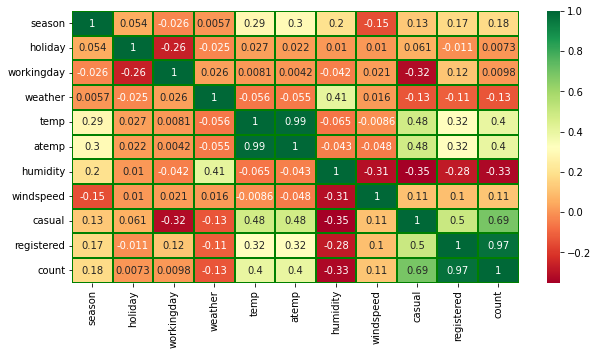

In [5]:
plt.figure(figsize = (10, 5))
sns.heatmap(df_train.corr(), cmap='RdYlGn',annot=True, linecolor='Green', linewidths=1.0)
plt.show()

Let's check the correlation between the variables and drop the variables that are highly correlated.

In [7]:
cols = ['season','holiday','workingday','weather','temp','humidity','windspeed']

In [8]:
model = RandomForestRegressor(n_estimators = 1)
print("columns selected for later:",cols)
print(model)

columns selected for later: ['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed']
RandomForestRegressor(n_estimators=1)


In [9]:
n = len(df_train) # get number of rows in the training set
training_size = 0.75 # fraction of training data to split off for internal testing

# separate training and testing sets
indices = np.array(range(n)) # makes an array of row indices in order
from numpy.random import shuffle
shuffle(indices)
split_point = int(n*training_size)
mytrain_i = indices[0:split_point]
mytest_i = indices[split_point:]

# now use those shuffled indices to separating training from test dataframes
new_train_df = df_train.iloc[mytrain_i]
new_test_df = df_train.iloc[mytest_i]

print("samples in the new training subset:",len(new_train_df))
print("samples in the new test subset:",len(new_test_df))

samples in the new training subset: 6880
samples in the new test subset: 2294


In [10]:
# fit the model to the training subset of original training data
model.fit(new_train_df[cols], new_train_df['count'])

# predict on the testing subset of the original training data
pred_count = model.predict(new_test_df[cols])

# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(new_test_df['count'],pred_count))
print("RMS error:",rms)

RMS error: 195.53841555249772


In [12]:
# read in the test data
url = 'https://raw.githubusercontent.com/suthapalliuday/INFO5502-Summer2022/main/datasets/lab_assignment_06/test_luc.csv'
df_test = pd.read_csv(url,index_col=False)

print("\nNumber of samples:",df_test.shape[0] ,"and number of features:",df_test.shape[1],"\n")

# show the test data output to be sure it read in correctly and added the column
df_test.head()

# fit the selected model 
model.fit( df_train[cols], df_train['count'])

# apply to the test data 

pred_count = model.predict(df_test[cols])

# add the prediction column 
df_test['count'] = pred_count

# save the predicted count as a csv 
df_test = df_test[['datetime','count']].to_csv('final_prediction.csv', 
    index=False, header=True)
print("Prediction complete. Saved as final_prediction.csv")




Number of samples: 1712 and number of features: 9 

Prediction complete. Saved as final_prediction.csv


 Question 2 (20 points) Build a regession model to predict the change in price of the stock overtime. It can either be linear regression or non-linear regression. You can download the dataset from here: https://github.com/suthapalliuday/INFO5502-Summer2022/blob/main/datasets/portfolio_data.csv. The implementation of the LSTM on this same dataset was posted here as an reference: https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm/notebook

 ### Your code

In [13]:
### You code here:
from datetime import datetime
url = 'https://raw.githubusercontent.com/suthapalliuday/INFO5502-Summer2022/main/datasets/portfolio_data.csv'
df_stock = pd.read_csv(url,index_col=False,parse_dates=["Date"])
df_stock.head()



,Date,AMZN,DPZ,BTC,NFLX
0,2013-05-01,248.229996,51.190983,106.250000,30.415714
1,2013-05-02,252.550003,51.987320,98.099998,30.641428
2,2013-05-03,258.049988,52.446388,112.900002,30.492857
3,2013-05-06,255.720001,53.205257,109.599998,30.098572
4,2013-05-07,257.730011,54.151505,113.199997,29.464285


In [19]:
nRow, nCol = df_stock.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1520 rows and 5 columns


Let's Visualize the historic price of stocks data

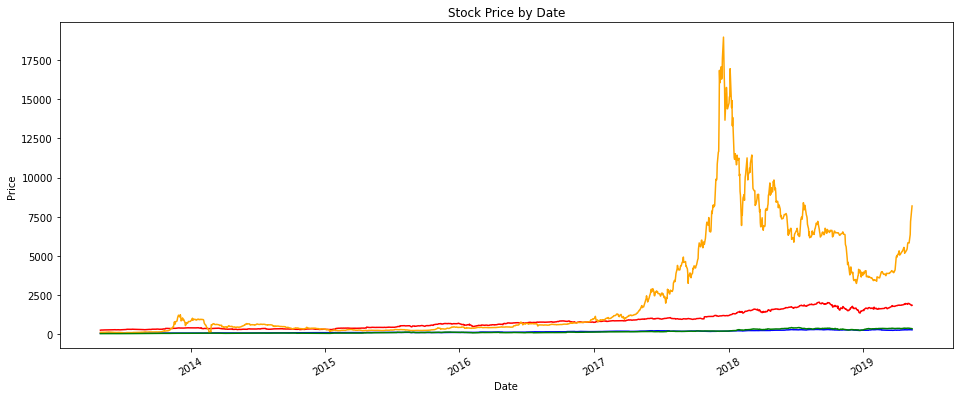

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
#plt.autoscale(enable=True, axis='y', tight=True)
#plt.ticklabel_format(style='plain')
plt.plot(df_stock['Date'],df_stock['AMZN'],color ='Red')
plt.plot(df_stock['Date'],df_stock['DPZ'],color = 'blue')
plt.plot(df_stock['Date'],df_stock['BTC'],color ='orange')
plt.plot(df_stock['Date'],df_stock['NFLX'],color ='green')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Price by Date")
plt.xticks(rotation=30)
#plt.rcParams['figure.figsize'] = [10,10]#width,height

plt.show()


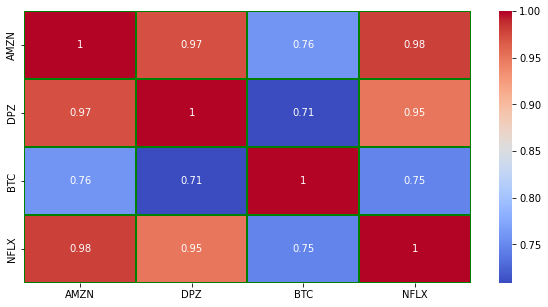

In [29]:
plt.figure(figsize = (10, 5))
sns.heatmap(df_stock.corr(), cmap='coolwarm',annot=True, linecolor='Green', linewidths=1.0)
plt.show()

Let's take only Amazon stock and visualize and predict the price of AMZN stock

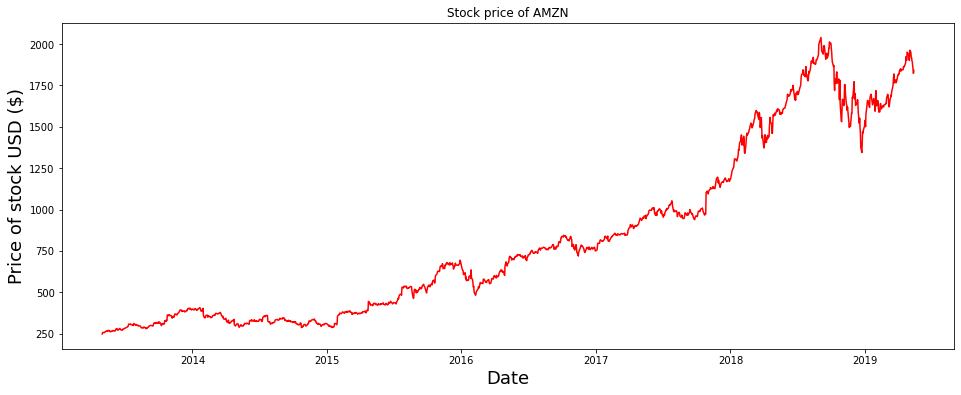

In [31]:
# AMZN	DPZ	BTC	NFLX
plt.figure(figsize=(16,6))
plt.title('Stock price of AMZN')
#plt.plot(df_stock['AMZN'])
plt.plot(df_stock['Date'],df_stock['AMZN'],color ='Red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price of stock USD ($)', fontsize=18)
plt.show()



In [32]:
# Create a new dataframe only with Amazon stock price
df_amzn = df_stock.filter(['AMZN'])
df_amzn.head()
                            


,AMZN
0,248.229996
1,252.550003
2,258.049988
3,255.720001
4,257.730011


In [33]:
# Convert the dataframe to a numpy array
dataset = df_amzn.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .90 ))

training_data_len

1368

In [34]:
 #Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.        ],
       [0.00241169],
       [0.00548211],
       ...,
       [0.91652336],
       [0.87895251],
       [0.88868853]])

Let's create and training dataset:

In [35]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


[array([0.        , 0.00241169, 0.00548211, 0.00418137, 0.00530348,
       0.00583382, 0.00666005, 0.00859721, 0.00908848, 0.01122102,
       0.01023291, 0.00887075, 0.01209749, 0.01083025, 0.0115169 ,
       0.00822317, 0.00757558, 0.00754209, 0.01064044, 0.0096579 ,
       0.01038363, 0.01170672, 0.01041155, 0.00975281, 0.01057345,
       0.01094189, 0.01598857, 0.01833326, 0.0148218 , 0.01308562,
       0.01538565, 0.01438077, 0.0166529 , 0.01871847, 0.01670873,
       0.01407374, 0.01402907, 0.01249385, 0.01332008, 0.01637935,
       0.01636818, 0.01644634, 0.01890827, 0.01981824, 0.01998571,
       0.02101849, 0.02364789, 0.02417266, 0.02461926, 0.02871132,
       0.03311598, 0.0325689 , 0.03273637, 0.0337524 , 0.03119556,
       0.03182083, 0.03084387, 0.02949288, 0.02830937, 0.0307992 ])]
[0.03560583130583625]

[array([0.        , 0.00241169, 0.00548211, 0.00418137, 0.00530348,
       0.00583382, 0.00666005, 0.00859721, 0.00908848, 0.01122102,
       0.01023291, 0.00887075, 0.01

In [36]:
# Build the model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1308/1308 [==============================] - 51s 36ms/step - loss: 0.0014


Let's create the test data

In [38]:

test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

72.74289473613464

Visualize the data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


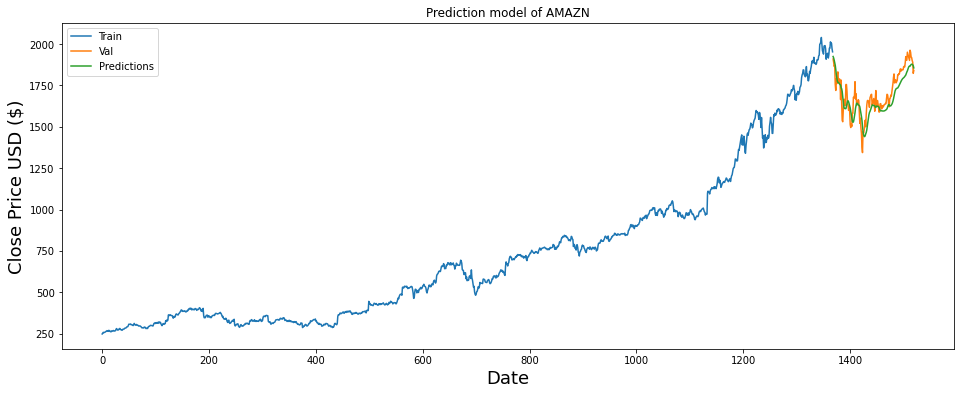

In [43]:

train = df_amzn[:training_data_len]
valid = df_amzn[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Prediction model of AMAZN')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
#plt.plot(df_stock['Date'],df_stock['AMZN'])
plt.plot(train['AMZN'])
plt.plot(valid[['AMZN', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()

In [44]:
# Show the valid and predicted prices
valid

,AMZN,Predictions
1368,1909.420044,1924.524048
1369,1889.650024,1915.833496
1370,1864.420044,1902.789185
1371,1870.319946,1886.530151
1372,1755.250000,1871.470947
...,...,...
1515,1917.770020,1877.997681
1516,1899.869995,1877.624390
1517,1889.979980,1874.258911
1518,1822.680054,1868.826050
